### Contrastive Learning

*In **Barlow Twins**, the objective function that naturally avoids collapse by measuring the cross-correlation matrix between the outputs of two identical networks fed with distorted versions of a sample, and making it as close to the identity matrix as possible. This causes the embedding vectors of distorted versions of a sample to be similar, while minimizing the redundancy between the components of these vectors. Barlow Twins does not require large batches nor asymmetry between the network twins such as a predictor network, gradient stopping, or a moving average on the weight updates.*

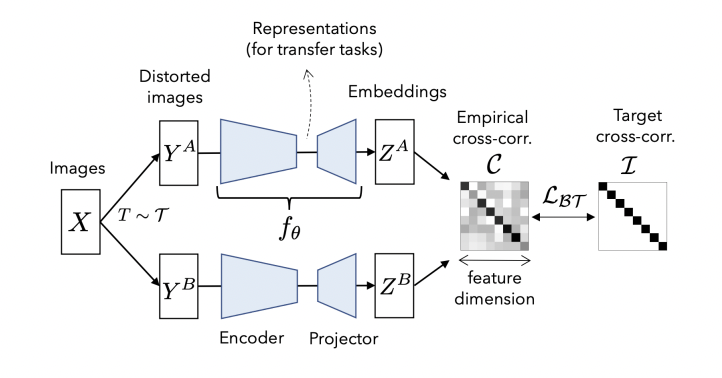

---
Zbontar, J., Jing, L., Misra, I., LeCun, Y., & Deny, S. (2021). [Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/pdf/2103.03230.pdf). ICML.

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

import os
import pandas as pd
from PIL import Image
import pickle
from functools import partial

In [2]:
CONFIG = {
    'SEED': 13,
    'DATA_PATH':'/scratch/va2134/medical-cv-csci-ga-2271/datasets/CheXpert-v1.0-small/',
    'DS_BASE_PATH':'/scratch/va2134/medical-cv-csci-ga-2271/datasets/',
    'BASE_PATH':'/scratch/va2134/medical-cv-csci-ga-2271/models/contrastive/',
    'WANDB_PROJECT':'medical-cv',
    'MAX_EPOCHS':50,
    'BATCH_SIZE':32,
    'NUM_WORKERS':2,
    'MODEL_SAVE_NAME':'barlow-resnet18'
}

In [3]:
_= pl.seed_everything(CONFIG['SEED'])
wandb_logger = WandbLogger(project=CONFIG['WANDB_PROJECT']) 

Global seed set to 13


In [4]:
with open(f"{CONFIG['DATA_PATH']}/train.pkl", 'rb') as f:
    train_studies = pickle.load(f)
with open(f"{CONFIG['DATA_PATH']}/valid.pkl", 'rb') as f:
    val_studies = pickle.load(f)

## Augmenations

**Standard Augmentations:** Random cropping, Random color,Jittering (strength = 0.5), Rotation (upto 45 degrees) and Horizontal flipping. Exclude Gaussian blur, because we think it can make it impossible to distinguish local texture variations and other areas of interest thereby changing the underlying disease interpretation the X-ray image.

**Multi-Instance Augmentation:** If a there are multiple views (For Example: *lateral* and *front*) available to a corresponding study, we train model to maximize agreement between the transformed versions of two views.

---

In [5]:
jitter_strength = 0.5
input_height = 224
degrees = 45
flip_prob = 0.5

augmentations = transforms.Compose(
    [
        transforms.RandomResizedCrop(input_height, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(p = flip_prob),
        transforms.RandomRotation(degrees = degrees),
        transforms.RandomApply(
            [
                transforms.ColorJitter(brightness = 0.8*jitter_strength, 
                                       contrast = 0.8*jitter_strength,
                                       saturation = 0.8*jitter_strength,
                                       hue = 0.2*jitter_strength
                                      )],
            p=0.8
        ),
        transforms.ToTensor(),
        # Honestly, not a fan of the following way of normalization
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]
)

In [6]:
class MultiInstanceSSLDataset(torch.utils.data.Dataset):
    def __init__(self, studies, transforms):
        self.studies = studies
        self.transforms =  transforms

    def __len__(self):
        return len(self.studies) 

    def get_sample(self, path):
        x = Image.open(f"{CONFIG['DS_BASE_PATH']}/{path}").convert('RGB')
        x = self.transforms(x)
        return x

    def __getitem__(self, idx):
        sample = self.studies[idx]
        if len(sample) > 1:
            # Multi-Instance Augmentation
            x = self.get_sample(sample[0])
            x̄ = self.get_sample(sample[-1])
        else:
            x = self.get_sample(sample[0])
            x̄ = self.get_sample(sample[0])
        return x,x̄

In [7]:
train_dataset = MultiInstanceSSLDataset(train_studies, augmentations)
val_dataset = MultiInstanceSSLDataset(val_studies, augmentations)

train_loader = torch.utils.data.DataLoader(
                          train_dataset, 
                          batch_size= CONFIG['BATCH_SIZE'], 
                          shuffle = True, num_workers = CONFIG['NUM_WORKERS'])
val_loader = torch.utils.data.DataLoader(
                        val_dataset, 
                        batch_size = CONFIG['BATCH_SIZE'], 
                        shuffle = False, num_workers = CONFIG['NUM_WORKERS'])

In [8]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff = 5e-3, z_dim = 128):
        super().__init__()
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        # taken from: https://github.com/facebookresearch/barlowtwins/blob/main/main.py
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        # N x D, where N is the batch size and D is output dim of projection head
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)

        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()
        return on_diag + self.lambda_coeff * off_diag

In [9]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim = 2048, hidden_dim = 2048, output_dim = 128):
        super().__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        return self.projection_head(x)

In [10]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0

def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

In [11]:
class BarlowTwins(pl.LightningModule):
    def __init__(
        self,
        encoder,
        encoder_out_dim,
        num_training_samples,
        batch_size,
        lambda_coeff=5e-3,
        z_dim=128,
        learning_rate=1e-4,
        warmup_epochs=10,
        max_epochs=50,
    ):
        super().__init__()

        self.encoder = encoder
        self.projection_head = ProjectionHead(input_dim=encoder_out_dim, hidden_dim=encoder_out_dim, output_dim=z_dim)
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size, lambda_coeff=lambda_coeff, z_dim=z_dim)

        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs

        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch):
        x, x̄ = batch

        z = self.projection_head(self.encoder(x))
        z̄ = self.projection_head(self.encoder(x̄))

        return self.loss_fn(z, z̄)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss.item(), on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [12]:
encoder =  resnet18(pretrained = False)

encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
encoder.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

encoder.fc = nn.Identity()

In [13]:
encoder_out_dim = 512
z_dim = 128

model = BarlowTwins(
    encoder = encoder,
    encoder_out_dim = encoder_out_dim,
    num_training_samples = len(train_dataset),
    batch_size = CONFIG['BATCH_SIZE'],
    z_dim = z_dim,
)

model_save_checkpoint = pl.callbacks.ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = f"{CONFIG['BASE_PATH']}/models",
    filename = f"{CONFIG['MODEL_SAVE_NAME']}"+'-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
)

trainer = pl.Trainer(
    max_epochs = CONFIG['MAX_EPOCHS'],
    gpus = torch.cuda.device_count(),
    precision = 16 if torch.cuda.device_count() > 0 else 32,
    callbacks = [model_save_checkpoint],
    logger = wandb_logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
